# Emotion Detection From Scratch

## Data Set-

Kaggle - https://www.kaggle.com/datasets/msambare/fer2013
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)



### Import Required Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import imghdr
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D,Dense,MaxPooling2D,BatchNormalization,Dropout,Flatten,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.optimizers import Adam,Adamax
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.applications import VGG16,ResNet50V2


from sklearn.metrics import confusion_matrix,classification_report,auc,roc_curve
from sklearn.utils import compute_class_weight

from keras.models import model_from_json

2024-07-13 15:24:41.453144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 15:24:41.453268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 15:24:41.614158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Setting up Directory to save model data

In [2]:
project_name = "Emotion_Detection"

model_names = [
    'custom_cnn_from_scratch',
    'custom_cnn_with_augmentation',
    'vgg16_transfer_learning',
    'resnet50_transfer_learning'
]


base_dir = "/kaggle/working/"


project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok=True)



for i in model_names :
    model_dir = os.path.join(project_dir,i)
    os.makedirs(model_dir,exist_ok=True)

### Data Cleaning

In [3]:
img_type = ['jpeg','jpg','png']

data_dir = '/kaggle/input/fer2013/train'


for root,dirs,files in os.walk(data_dir):
    for single_file in files:
        file_path = os.path.join(root,single_file)

        try:
            file_type = imghdr.what(file_path)

            if file_type not in img_type:
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            os.remove(file_path)

### Data Analysis

In [4]:
def files_count_in_subdirs(dir_name,set_name):
    count={}

    for sub_dir_name in os.listdir(dir_name):
        sub_dir_path = os.path.join(dir_name,sub_dir_name)

        if os.path.isdir(sub_dir_path):
            count[sub_dir_name] = len(os.listdir(sub_dir_path))


    df = pd.DataFrame(count,index=[set_name])
    return df

In [5]:
train_dir = '/kaggle/input/fer2013/train'

train_count = files_count_in_subdirs(train_dir,'train')
train_count

,surprise,fear,angry,neutral,sad,disgust,happy
train,3171,4097,3995,4965,4830,436,7215


<Axes: >

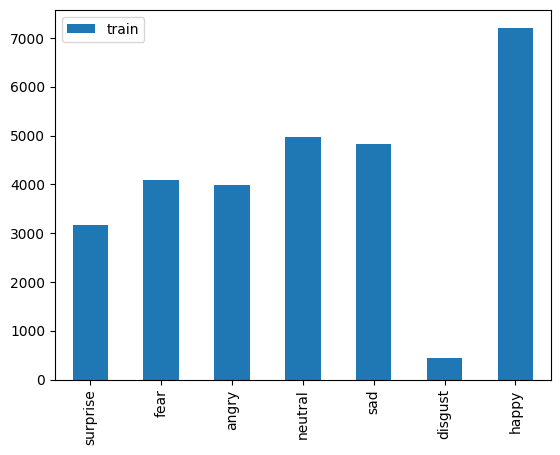

In [6]:
train_count.T.plot(kind='bar')

In [7]:
test_dir = '/kaggle/input/fer2013/test'

test_count = files_count_in_subdirs(test_dir,'test')
test_count

,surprise,fear,angry,neutral,sad,disgust,happy
test,831,1024,958,1233,1247,111,1774


<Axes: >

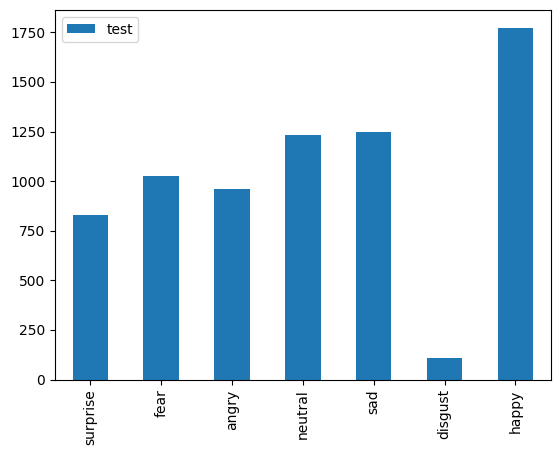

In [8]:
test_count.T.plot(kind='bar')

### plotting one image from each emotion

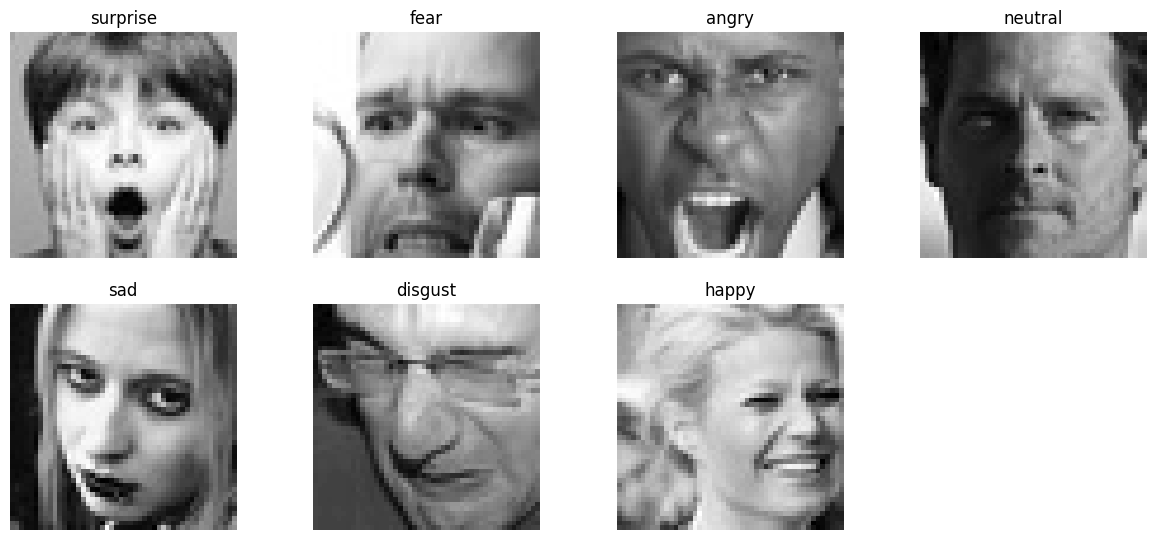

In [9]:
train_dir = '/kaggle/input/fer2013/train'

emotions = os.listdir(train_dir)

plt.figure(figsize=(15,10))


for i,single_emotion in enumerate(emotions,1):
    folder = os.path.join(train_dir,single_emotion)
    img_path = os.path.join(folder,os.listdir(folder)[101])
    img = plt.imread(img_path)

    plt.subplot(3,4,i)
    plt.imshow(img,cmap='gray')
    plt.title(single_emotion)
    plt.axis('off')

### Plotting random images from given directory

In [10]:
def plot_img(directory_path , class_name , num_img=9):
    img_path = os.listdir(directory_path)

    if len(img_path) < num_img :
        num_img = len(img_path)

    random_pics = random.sample(img_path,num_img)

    fig,axes = plt.subplots(3,3,figsize=(8,8))
    axes = axes.ravel()

    for i,img_file in enumerate(random_pics):
        img_path = os.path.join(directory_path,img_file)

        image = load_img(img_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image : {class_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

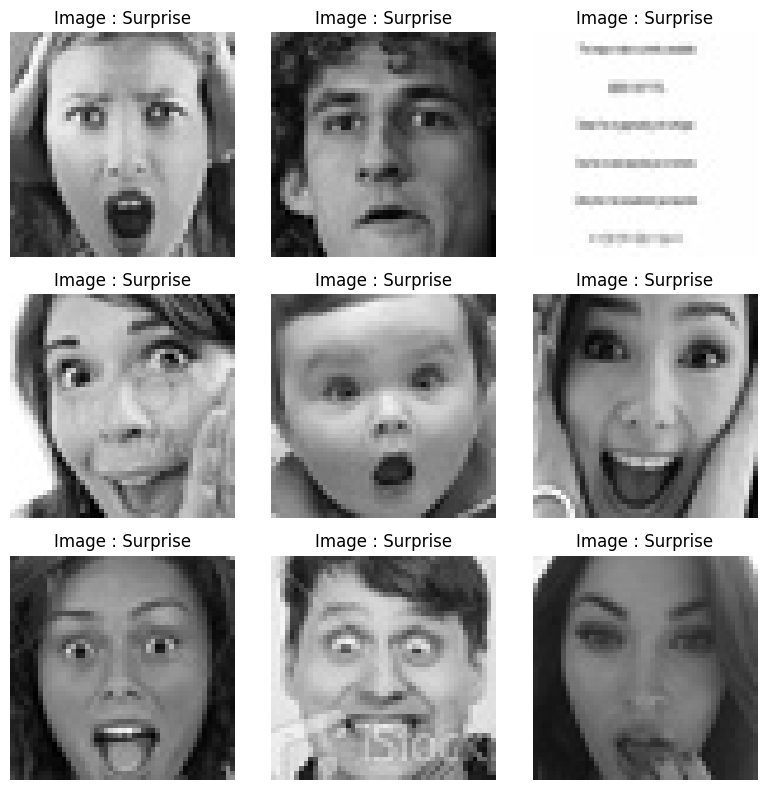

In [11]:
surprise_directory_path = '/kaggle/input/fer2013/train/surprise'
plot_img(surprise_directory_path,class_name='Surprise')

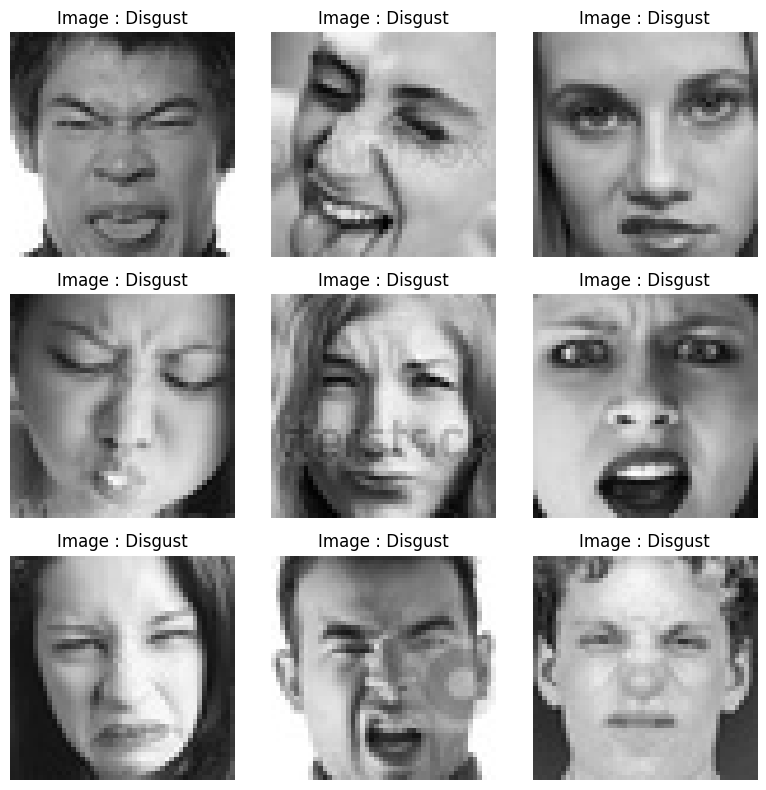

In [12]:
disgust_directory_path = '/kaggle/input/fer2013/train/disgust'
plot_img(disgust_directory_path,class_name='Disgust')

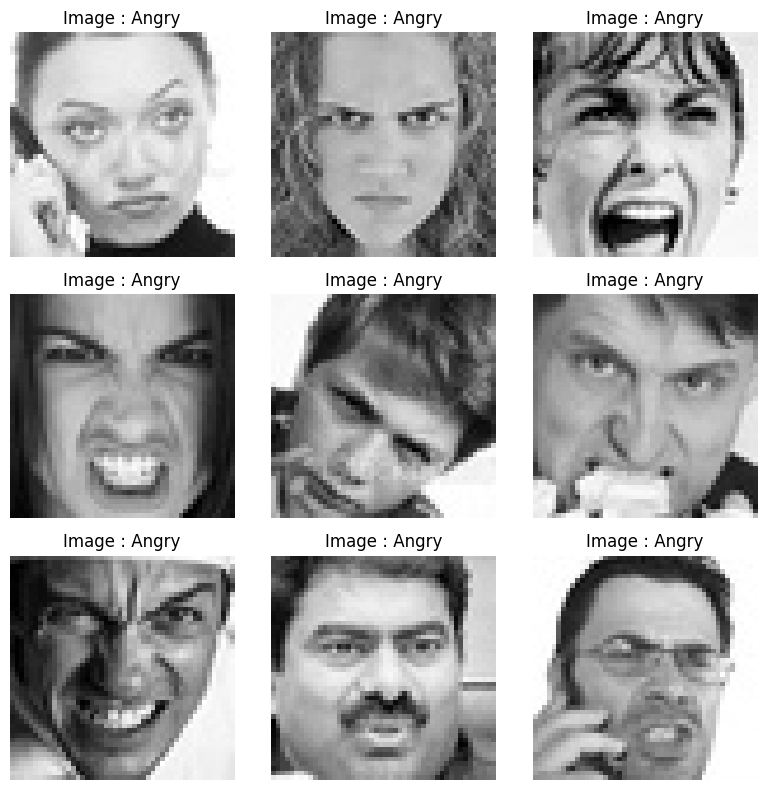

In [13]:
angry_directory_path = '/kaggle/input/fer2013/train/angry'
plot_img(angry_directory_path,class_name='Angry')

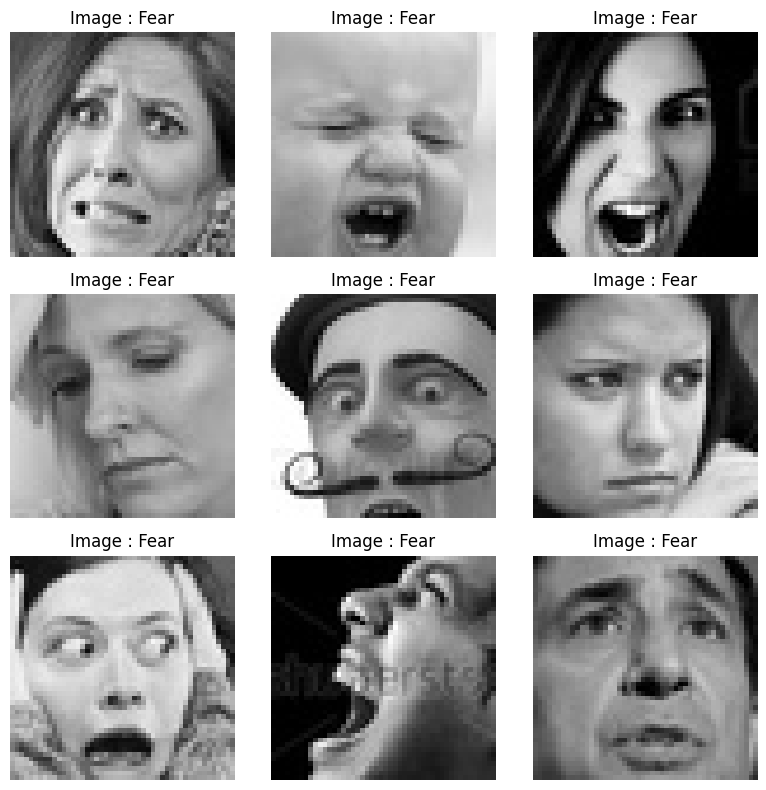

In [14]:
fear_directory_path = '/kaggle/input/fer2013/train/fear'
plot_img(fear_directory_path,class_name='Fear')

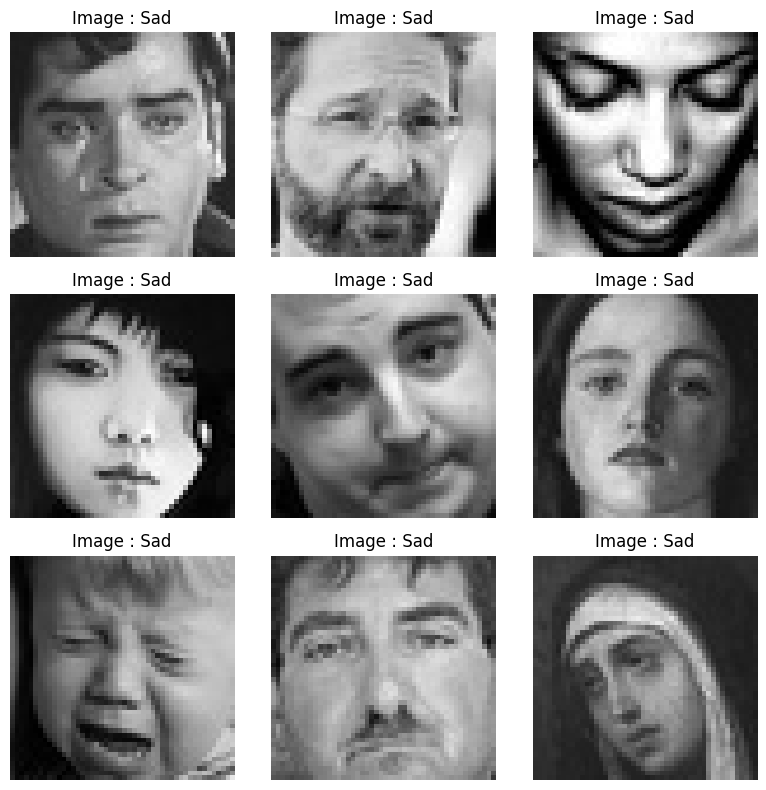

In [15]:
sad_directory_path = '/kaggle/input/fer2013/train/sad'
plot_img(sad_directory_path,class_name='Sad')

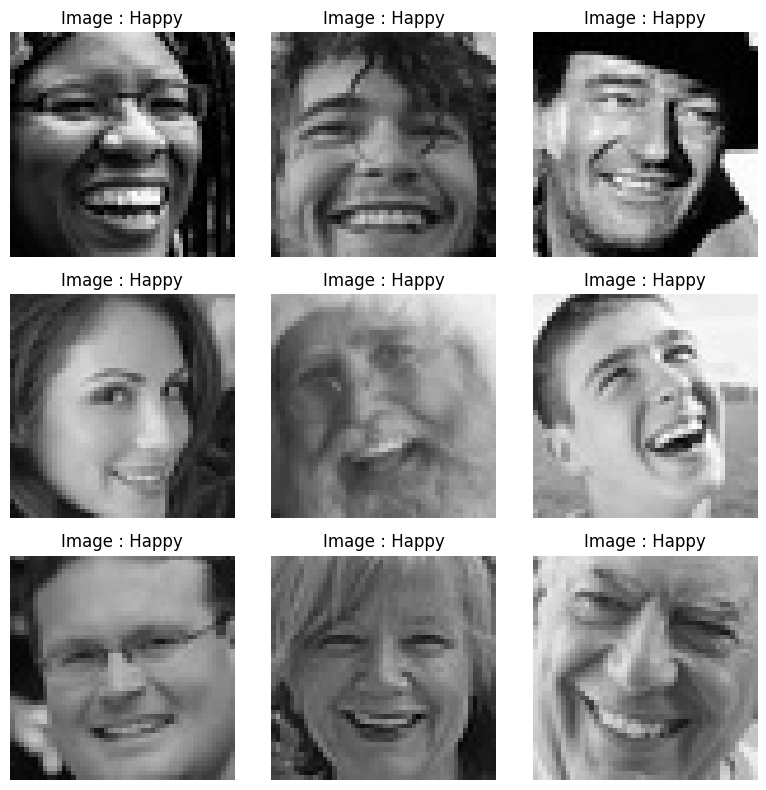

In [16]:
happy_directory_path = '/kaggle/input/fer2013/train/happy'
plot_img(happy_directory_path,class_name='Happy')

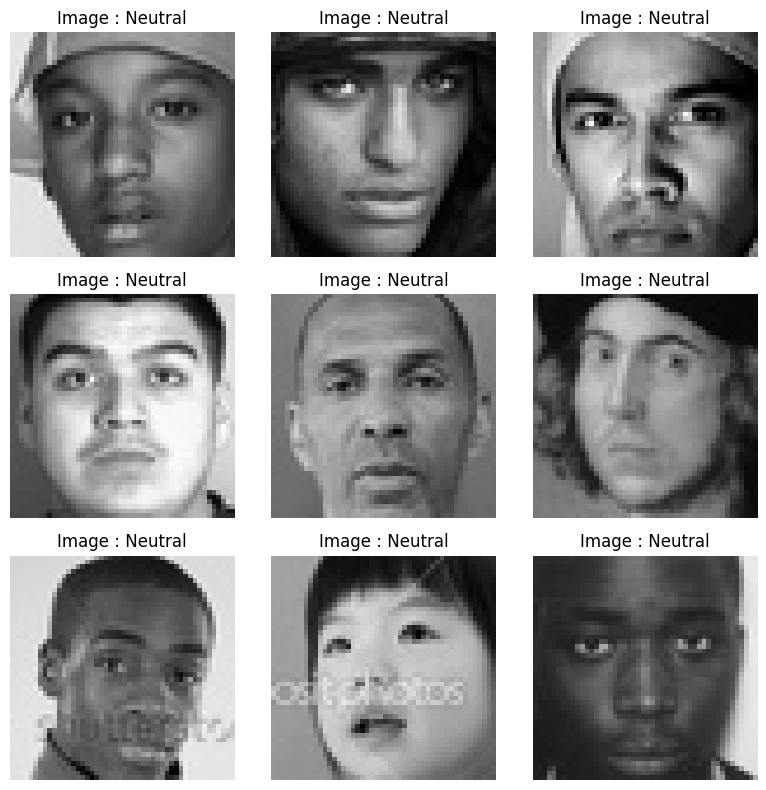

In [17]:
neutral_directory_path = '/kaggle/input/fer2013/train/neutral'
plot_img(neutral_directory_path,class_name='Neutral')

### Checking shapes & channels

In [18]:
image = '/kaggle/input/fer2013/train/disgust/Training_10371709.jpg'

img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)

if img is not None:
  print(img.shape)
else:
  print("Image could not be loaded")

(48, 48)


## Model 1 : Custom CNN From Scratch

In [20]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [21]:
img_width , img_height = 48 , 48
batch_size = 64
epochs = 10
num_class = 7

In [22]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [23]:
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'
)


val_generator = data_gen.flow_from_directory(
    train_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)


test_generator = data_gen.flow_from_directory(
    test_dir,
    target_size = (img_width,img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

validation_class_labels = val_generator.class_indices
print("Validation class labels:", validation_class_labels)

test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [25]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',input_shape=(img_width,img_height,1)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(num_class,activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

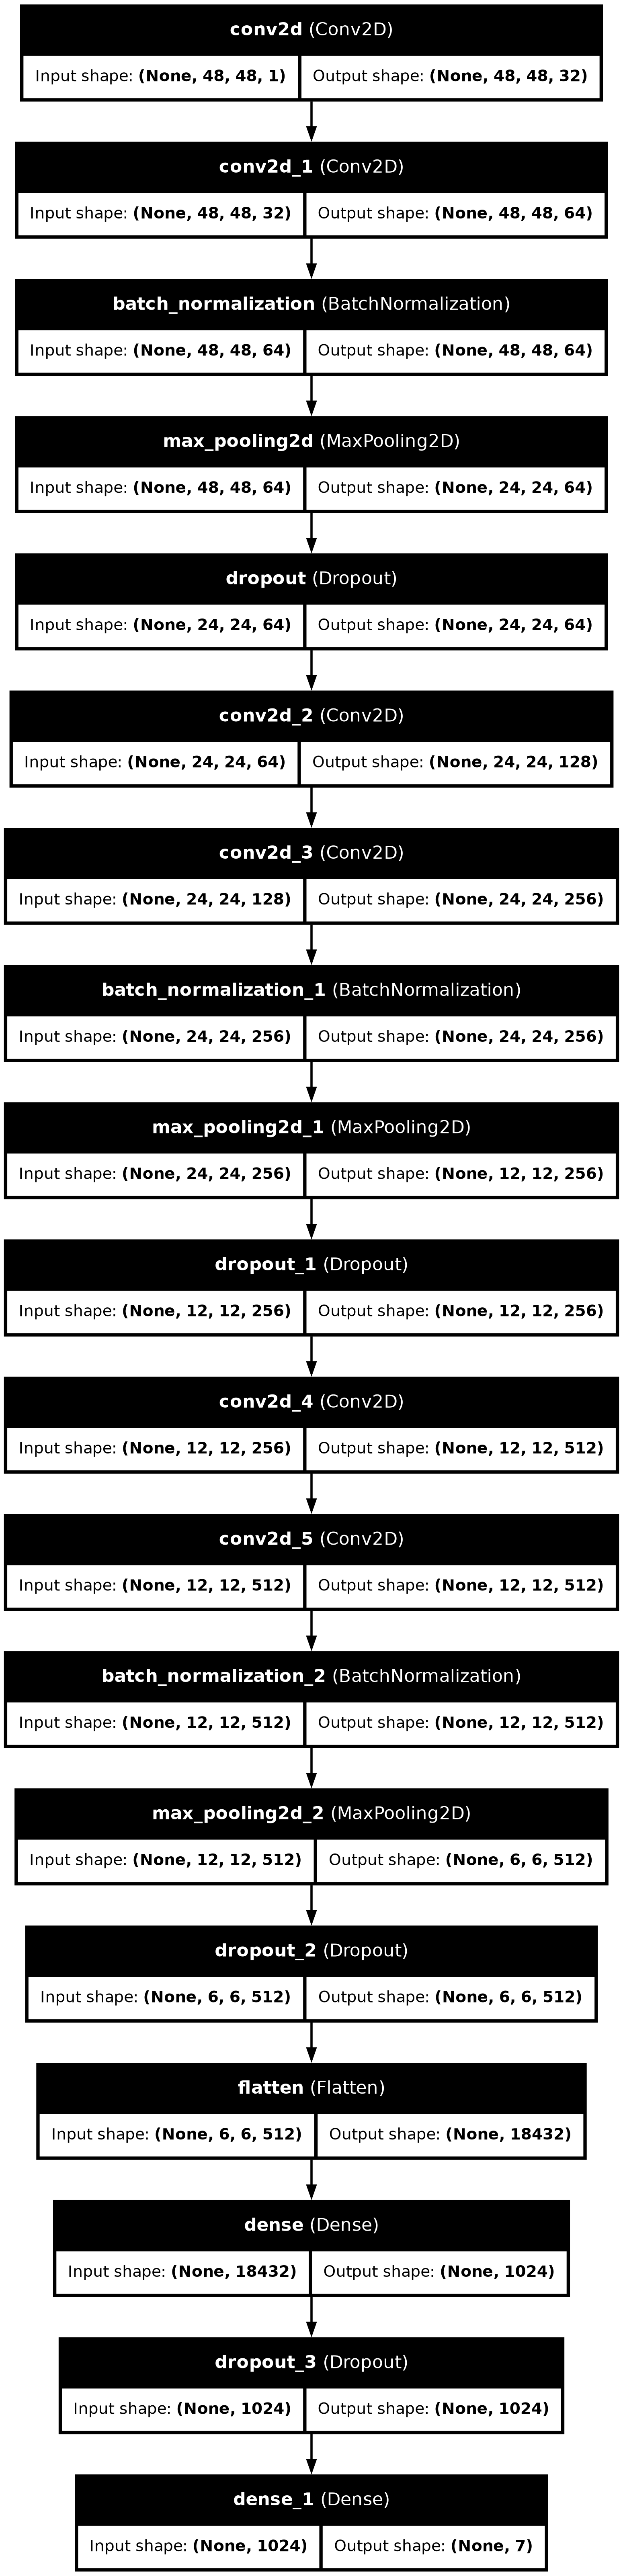

In [26]:
plot_model(model, to_file = '/kaggle/working/Emotion_Detection/custom_cnn_from_scratchArchitecture.png',
           show_shapes=True, show_layer_names=True)

In [27]:
cnn_path = '/kaggle/working/Emotion_Detection/custom_cnn_from_scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')


earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps_epoch = val_generator.samples // val_generator.batch_size
test_steps_epoch = test_generator.samples // test_generator.batch_size

In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=val_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/358 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.1680 - loss: 17.7146   

I0000 00:00:1720535232.083516     132 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720535232.111526     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


354/358 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2400 - loss: 13.4405

W0000 00:00:1720535268.569189     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


357/358 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2403 - loss: 13.4319

W0000 00:00:1720535270.298747     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 16.65320, saving model to /kaggle/working/Emotion_Detection/custom_cnn_from_scratch/Custom_CNN_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 68s 123ms/step - accuracy: 0.2405 - loss: 13.4262 - val_accuracy: 0.1396 - val_loss: 16.6532 - learning_rate: 1.0000e-04
Epoch 2/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.3125 - loss: 11.2020

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 16.65320 to 15.87864, saving model to /kaggle/working/Emotion_Detection/custom_cnn_from_scratch/Custom_CNN_model.keras


W0000 00:00:1720535280.700109     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


358/358 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3125 - loss: 11.2020 - val_accuracy: 0.2000 - val_loss: 15.8786 - learning_rate: 1.0000e-04
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3363 - loss: 10.6202
Epoch 3: val_loss improved from 15.87864 to 9.55332, saving model to /kaggle/working/Emotion_Detection/custom_cnn_from_scratch/Custom_CNN_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 25s 69ms/step - accuracy: 0.3364 - loss: 10.6187 - val_accuracy: 0.3755 - val_loss: 9.5533 - learning_rate: 1.0000e-04
Epoch 4/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.3125 - loss: 9.1616
Epoch 4: val_loss did not improve from 9.55332
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.3125 - loss: 9.1616 - val_accuracy: 0.3333 - val_loss: 9.9493 - learning_rate: 1.0000e-04
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3791 - loss: 8.4768
Epoch 5: val_loss improved from 9.55332 to 7.21650, saving model to /kaggle/working/Emotion_Detect

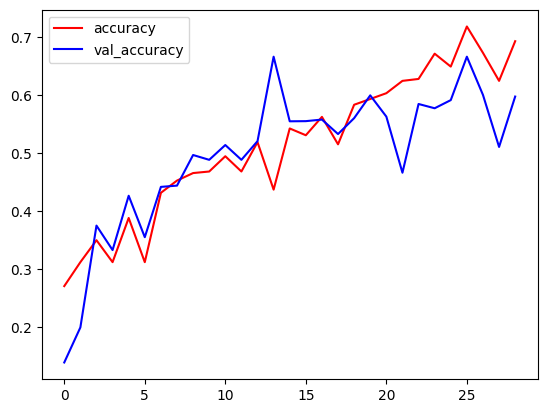

In [31]:
plt.plot(history.history['accuracy'],color='red',label='accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='val_accuracy')
plt.legend()
plt.show()

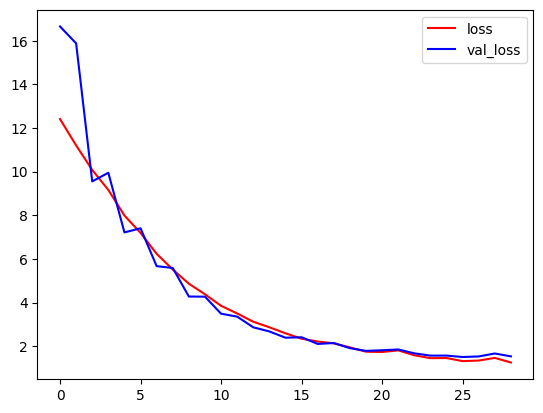

In [32]:
plt.plot(history.history['loss'],color='red',label='loss')
plt.plot(history.history['val_loss'],color='blue',label='val_loss')
plt.legend()
plt.show()

In [33]:
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)

print(f"Accuracy : {train_accu*100}")
print(f"Validation Accuracy : {test_accu*100}")

359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.7423 - loss: 1.2088


W0000 00:00:1720535680.087806     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 33s 293ms/step - accuracy: 0.5829 - loss: 1.6034
Accuracy : 73.89847040176392
Validation Accuracy : 59.45945978164673


W0000 00:00:1720535713.584351     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [34]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [35]:
# predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)

predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples / test_generator.batch_size))), axis=1)
predicted_classes

  5/113 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step  

W0000 00:00:1720535714.328799     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step


W0000 00:00:1720535720.507525     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([0, 5, 3, ..., 0, 0, 0])

In [36]:
class_labels = list(test_generator.class_indices.keys())
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [37]:
cm = confusion_matrix(true_classes,predicted_classes)
cm

array([[144,  11,  96, 225, 175, 197, 110],
       [ 13,   0,  12,  25,  30,  20,  11],
       [158,   5, 106, 247, 161, 222, 125],
       [267,  11, 182, 419, 332, 347, 216],
       [201,  15, 124, 294, 219, 239, 141],
       [189,   8, 130, 254, 228, 272, 166],
       [135,   3,  77, 200, 157, 163,  96]])

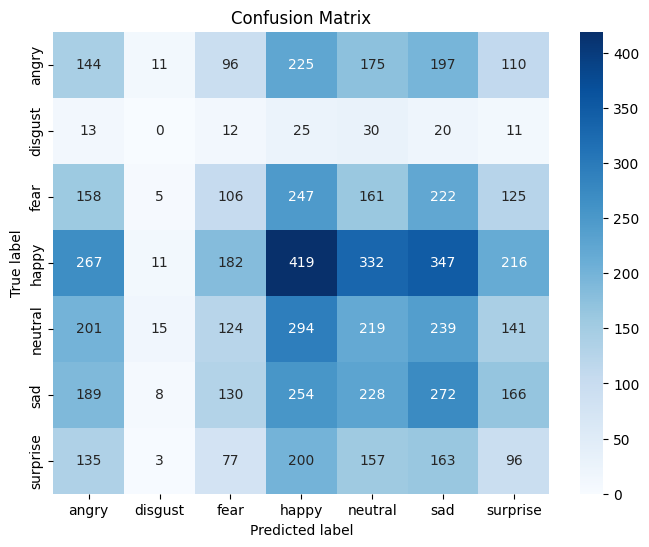

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

- Precision: The ratio of correctly predicted positive observations to the total predicted positives. Precision is a measure of the accuracy of the positive predictions.



- Recall (Sensitivity or True Positive Rate): The ratio of correctly predicted positive observations to all observations in the actual class. Recall measures the ability of the model to find all the relevant cases within a dataset.


- F1-Score: The weighted average of Precision and Recall. It is useful when you need a balance between precision and recall and when there is an uneven class distribution.


In [39]:
report = classification_report(true_classes,predicted_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.13      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.10      0.12      1024
       happy       0.25      0.24      0.24      1774
     neutral       0.17      0.18      0.17      1233
         sad       0.19      0.22      0.20      1247
    surprise       0.11      0.12      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



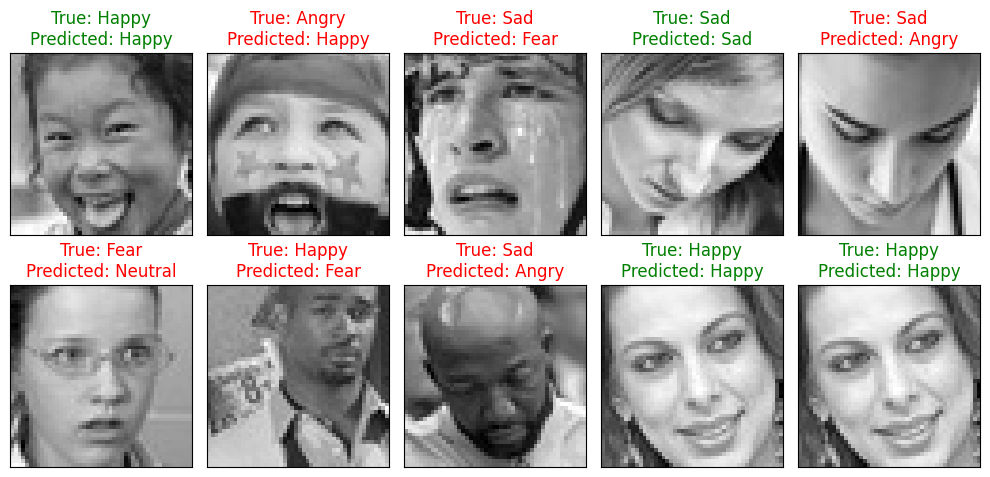

In [40]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [43]:
model.save_weights("/kaggle/working/Emotion_Detection/custom_cnn_from_scratch/custom_cnn_model.weights.h5")

In [44]:
model.load_weights("/kaggle/working/Emotion_Detection/custom_cnn_from_scratch/custom_cnn_model.weights.h5")

In [47]:
model_json = model.to_json()
with open("/kaggle/working/Emotion_Detection/custom_cnn_from_scratch/custom_cnn_model.json", "w") as json_file:
    json_file.write(model_json)

In [49]:
json_file = open('/kaggle/working/Emotion_Detection/custom_cnn_from_scratch/custom_cnn_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/kaggle/working/Emotion_Detection/custom_cnn_from_scratch/custom_cnn_model.weights.h5")

In [50]:
model.evaluate(test_generator)

  4/113 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5540 - loss: 1.6595

W0000 00:00:1720536341.274980     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.5930 - loss: 1.5811


W0000 00:00:1720536347.860109     134 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1.5791577100753784, 0.5945945978164673]

## Model 2 : Image Augmentation


In [42]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [43]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

In [44]:
data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


test_gen = ImageDataGenerator(
    rescale = 1./255
)

In [45]:
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)


val_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)


test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


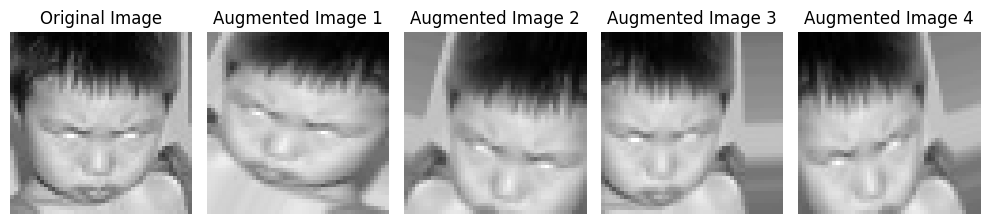

In [46]:
# Path to your specific image
image_path = '/kaggle/input/fer2013/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_gen.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch
    # save image
    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [47]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same',kernel_initializer='he_normal',input_shape=(img_width,img_height,1)))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(num_classes,activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │    18,875,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,813,703 (87.03 MB)

 Trainable params: 22,812,039 (87.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [48]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
cnn_path = '/kaggle/working/Emotion_Detection/custom_cnn_with_augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case


In [50]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps_epoch = val_generator.samples // val_generator.batch_size
test_steps_epoch = test_generator.samples // test_generator.batch_size

In [51]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    validation_data=val_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/358 ━━━━━━━━━━━━━━━━━━━━ 24s 70ms/step - accuracy: 0.2188 - loss: 16.1208   

I0000 00:00:1720537036.627516     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720537036.654825     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/358 ━━━━━━━━━━━━━━━━━━━━ 45s 216ms/step - accuracy: 0.2028 - loss: 14.2756

W0000 00:00:1720537068.061259     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2108 - loss: 13.4065

W0000 00:00:1720537088.557596     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 14.84277, saving model to /kaggle/working/Emotion_Detection/custom_cnn_with_augmentation/Custom_CNN_augmented_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 86s 169ms/step - accuracy: 0.2108 - loss: 13.4037 - val_accuracy: 0.0302 - val_loss: 14.8428 - learning_rate: 1.0000e-04
Epoch 2/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.2031 - loss: 11.1417

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 14.84277
358/358 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2031 - loss: 11.1417 - val_accuracy: 0.0444 - val_loss: 15.6867 - learning_rate: 1.0000e-04
Epoch 3/50


W0000 00:00:1720537101.480168     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2444 - loss: 10.5515
Epoch 3: val_loss improved from 14.84277 to 9.08421, saving model to /kaggle/working/Emotion_Detection/custom_cnn_with_augmentation/Custom_CNN_augmented_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.2444 - loss: 10.5498 - val_accuracy: 0.2425 - val_loss: 9.0842 - learning_rate: 1.0000e-04
Epoch 4/50
  1/358 ━━━━━━━━━━━━━━━━━━━━ 23s 65ms/step - accuracy: 0.1875 - loss: 8.7697
Epoch 4: val_loss improved from 9.08421 to 8.88932, saving model to /kaggle/working/Emotion_Detection/custom_cnn_with_augmentation/Custom_CNN_augmented_model.keras
358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1875 - loss: 8.7697 - val_accuracy: 0.2222 - val_loss: 8.8893 - learning_rate: 1.0000e-04
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2458 - loss: 8.1949
Epoch 5: val_loss improved from 8.88932 to 6.77136, saving model to /kaggle/working/Emotion_Detection/custom_cnn_with_augment

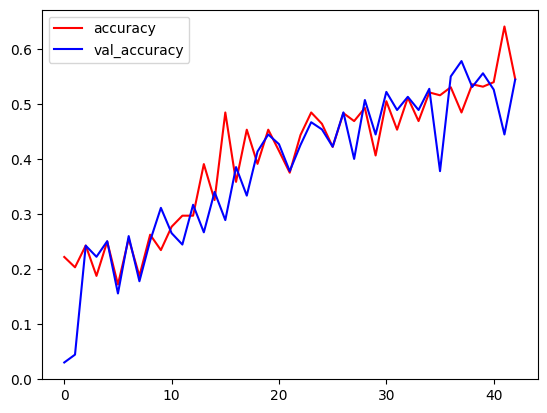

In [52]:
plt.plot(history.history['accuracy'],color='red',label='accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='val_accuracy')
plt.legend()
plt.show()

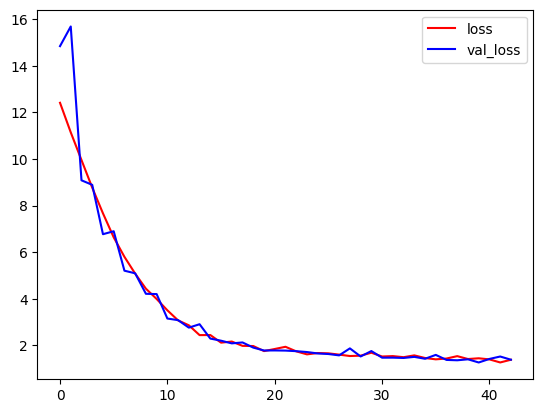

In [53]:
plt.plot(history.history['loss'],color='red',label='loss')
plt.plot(history.history['val_loss'],color='blue',label='val_loss')
plt.legend()
plt.show()

In [54]:
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)

print(f"Accuracy : {train_accu*100}")
print(f"Validation Accuracy : {test_accu*100}")

359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.5446 - loss: 1.3704


W0000 00:00:1720538003.913313     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 34s 301ms/step - accuracy: 0.5522 - loss: 1.3599
Accuracy : 54.7196090221405
Validation Accuracy : 54.70883250236511


W0000 00:00:1720538038.413510     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [55]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [56]:
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
predicted_classes

  5/113 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step 

W0000 00:00:1720538039.180966     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step


W0000 00:00:1720538046.331054     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([0, 0, 0, ..., 6, 3, 0])

In [57]:
class_labels = list(test_generator.class_indices.keys())
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [58]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[174,   0,  34, 199, 335,  62, 154],
       [ 20,   0,   7,  22,  32,   8,  22],
       [184,   1,  57, 219, 360,  65, 138],
       [299,   1,  97, 371, 593, 125, 288],
       [222,   1,  64, 271, 408,  78, 189],
       [236,   0,  70, 234, 431,  82, 194],
       [160,   0,  46, 157, 290,  57, 121]])

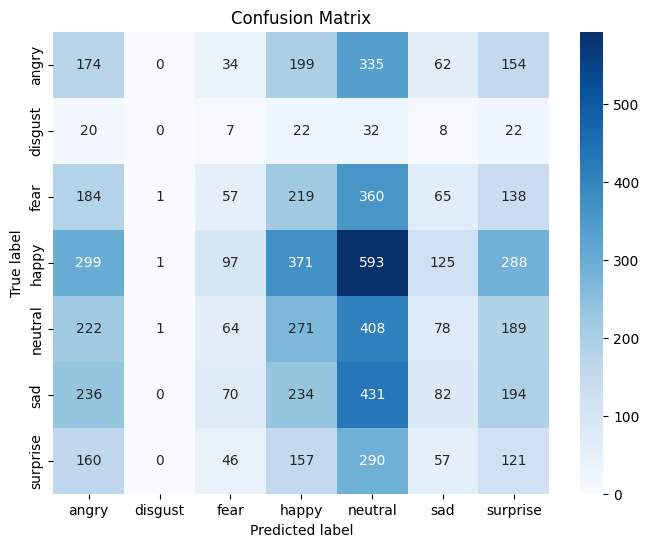

In [59]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [60]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.18      0.15       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.06      0.08      1024
       happy       0.25      0.21      0.23      1774
     neutral       0.17      0.33      0.22      1233
         sad       0.17      0.07      0.10      1247
    surprise       0.11      0.15      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.16      7178



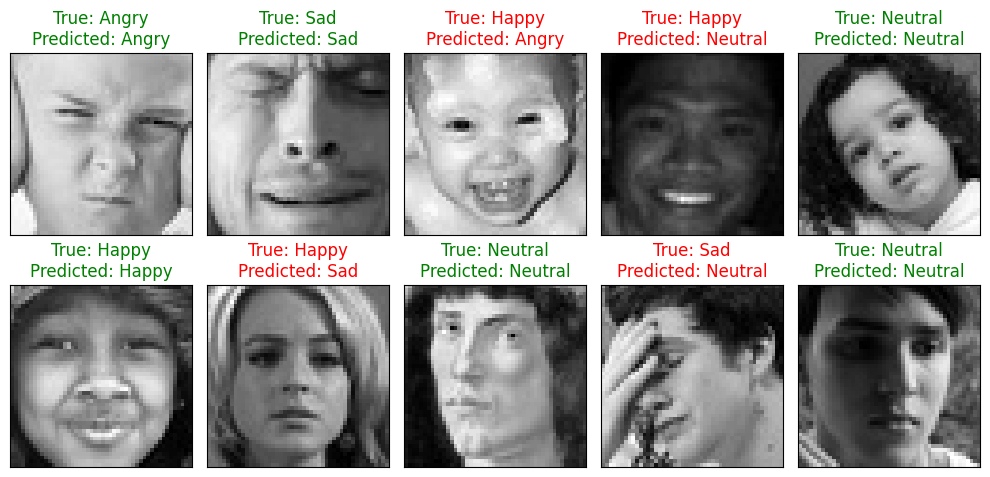

In [61]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [62]:
model.save_weights("/kaggle/working/Emotion_Detection/custom_cnn_with_augmentation/custom_cnn_augmentation_model.weights.h5")

In [63]:
model.load_weights("/kaggle/working/Emotion_Detection/custom_cnn_with_augmentation/custom_cnn_augmentation_model.weights.h5")

In [64]:
model_json = model.to_json()
with open("/kaggle/working/Emotion_Detection/custom_cnn_with_augmentation/custom_cnn_augmentation_model.json", "w") as json_file:
    json_file.write(model_json)

In [65]:
json_file = open('/kaggle/working/Emotion_Detection/custom_cnn_with_augmentation/custom_cnn_augmentation_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/kaggle/working/Emotion_Detection/custom_cnn_with_augmentation/custom_cnn_augmentation_model.weights.h5")

In [66]:
model.evaluate(test_generator)

  4/113 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5566 - loss: 1.3816

W0000 00:00:1720538278.946597     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.5477 - loss: 1.3582


W0000 00:00:1720538286.595681     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1.3554370403289795, 0.5470883250236511]

## Model 3 : Transfer Learning VGGNET

In [19]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [20]:
img_width, img_height = 224, 224
batch_size = 64
epochs = 10
num_classes = 7

In [21]:
data_gen = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest'
                                )

test_gen = ImageDataGenerator(
    rescale = 1 / 255.,
)

In [22]:
train_generator = data_gen.flow_from_directory(
                                train_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_gen.flow_from_directory(
                                test_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)
classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [24]:
# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

class_weights

array([1.02660468, 9.40661861, 1.00104606, 0.56843877, 0.82603942,
       0.84912748, 1.29337298])

In [25]:
# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [26]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [27]:
tf.keras.backend.clear_session()

vgg = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
for layer in vgg.layers[:-3]:
    layer.trainable = False


vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [29]:
x = Flatten()(vgg.output)

x = Dense(1024,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512,activation='relu',kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)

output = Dense(7,activation='softmax',kernel_initializer='he_normal')(x)

In [30]:
model = Model(inputs=vgg.input,outputs=output)

In [31]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,59

 Total params: 40,934,215 (156.15 MB)

 Trainable params: 30,939,143 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [33]:
cnn_path = '/kaggle/working/Emotion_Detection/vgg16_transfer_learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [34]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
test_steps_epoch = test_generator.samples // test_generator.batch_size

In [35]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=50,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720716476.512604     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720716476.539623     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/448 ━━━━━━━━━━━━━━━━━━━━ 3:33 711ms/step - accuracy: 0.1771 - loss: 2.0804

W0000 00:00:1720716622.745173     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.2272 - loss: 1.9350

W0000 00:00:1720716835.514493     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 1.48856, saving model to /kaggle/working/Emotion_Detection/vgg16_transfer_learning/VGG16_Transfer_Learning.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 476s 910ms/step - accuracy: 0.2274 - loss: 1.9347 - val_accuracy: 0.4429 - val_loss: 1.4886 - learning_rate: 1.0000e-04
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:19 311ms/step - accuracy: 0.3125 - loss: 2.3770

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 1.48856 to 1.45339, saving model to /kaggle/working/Emotion_Detection/vgg16_transfer_learning/VGG16_Transfer_Learning.keras


W0000 00:00:1720716896.356356     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


448/448 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.3125 - loss: 2.3770 - val_accuracy: 0.4000 - val_loss: 1.4534 - learning_rate: 1.0000e-04
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.3821 - loss: 1.6243
Epoch 3: val_loss improved from 1.45339 to 1.40554, saving model to /kaggle/working/Emotion_Detection/vgg16_transfer_learning/VGG16_Transfer_Learning.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 356s 784ms/step - accuracy: 0.3822 - loss: 1.6242 - val_accuracy: 0.4646 - val_loss: 1.4055 - learning_rate: 1.0000e-04
Epoch 4/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 2:13 298ms/step - accuracy: 0.4219 - loss: 1.9497
Epoch 4: val_loss did not improve from 1.40554
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 146us/step - accuracy: 0.4219 - loss: 1.9497 - val_accuracy: 0.3000 - val_loss: 1.4482 - learning_rate: 1.0000e-04
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.4253 - loss: 1.4917
Epoch 5: val_loss improved from 1.40554 to 1.40516, saving model to /kaggle/working/Emot

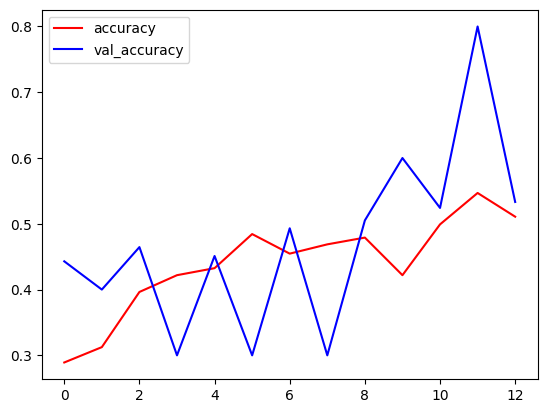

In [36]:
plt.plot(history.history['accuracy'],color='red',label='accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='val_accuracy')
plt.legend()
plt.show()

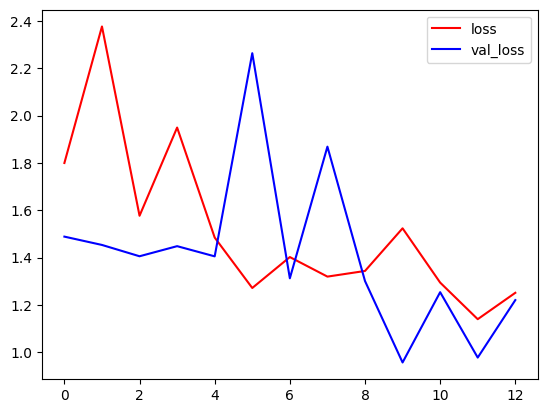

In [37]:
plt.plot(history.history['loss'],color='red',label='loss')
plt.plot(history.history['val_loss'],color='blue',label='val_loss')
plt.legend()
plt.show()

In [38]:
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)

print(f"Accuracy : {train_accu*100}")
print(f"Validation Accuracy : {test_accu*100}")

449/449 ━━━━━━━━━━━━━━━━━━━━ 325s 722ms/step - accuracy: 0.5009 - loss: 1.3069


W0000 00:00:1720719367.544168     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 253ms/step - accuracy: 0.5075 - loss: 1.2888
Accuracy : 50.346583127975464
Validation Accuracy : 50.668710470199585


In [39]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [40]:
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
predicted_classes

  1/113 ━━━━━━━━━━━━━━━━━━━━ 1:37 875ms/step

W0000 00:00:1720719397.849717     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 249ms/step


W0000 00:00:1720719425.746124     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([4, 6, 5, ..., 4, 4, 3])

In [41]:
class_labels = list(test_generator.class_indices.keys())
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [42]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[ 69,  90,  29, 256, 195, 116, 203],
       [  9,   9,   2,  27,  20,  22,  22],
       [ 73,  91,  31, 252, 204, 149, 224],
       [133, 145,  49, 476, 362, 229, 380],
       [ 98, 123,  41, 317, 265, 174, 215],
       [ 88, 110,  43, 336, 271, 138, 261],
       [ 67,  72,  33, 225, 162, 116, 156]])

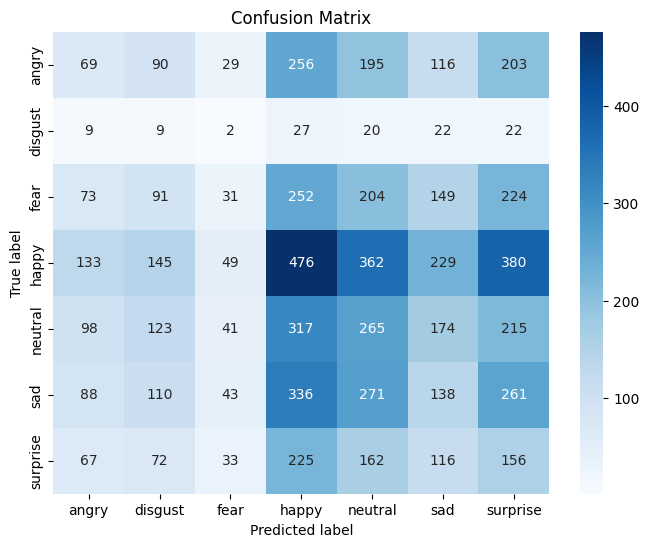

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.07      0.09       958
     disgust       0.01      0.08      0.02       111
        fear       0.14      0.03      0.05      1024
       happy       0.25      0.27      0.26      1774
     neutral       0.18      0.21      0.20      1233
         sad       0.15      0.11      0.13      1247
    surprise       0.11      0.19      0.14       831

    accuracy                           0.16      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.16      0.16      7178



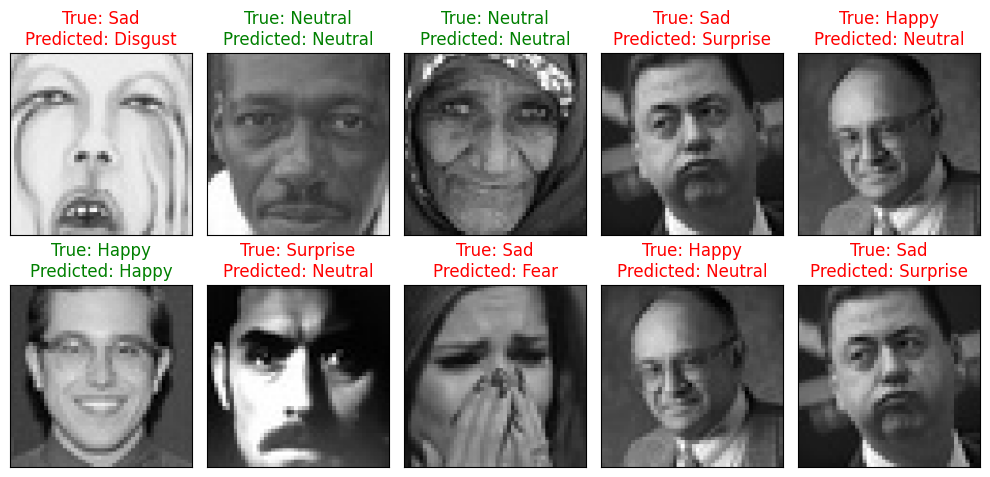

In [45]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [46]:
model.save_weights("/kaggle/working/Emotion_Detection/vgg16_transfer_learning/vgg16_model.weights.h5")

In [47]:
model.load_weights("/kaggle/working/Emotion_Detection/vgg16_transfer_learning/vgg16_model.weights.h5")

In [48]:
model_json = model.to_json()
with open("/kaggle/working/Emotion_Detection/vgg16_transfer_learning/vgg16_model.json", "w") as json_file:
    json_file.write(model_json)

In [49]:
json_file = open('/kaggle/working/Emotion_Detection/vgg16_transfer_learning/vgg16_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/kaggle/working/Emotion_Detection/vgg16_transfer_learning/vgg16_model.weights.h5")

In [50]:
model.evaluate(test_generator)

W0000 00:00:1720719437.083744     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 30s 251ms/step - accuracy: 0.5050 - loss: 1.2836


W0000 00:00:1720719465.456520     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[1.292644739151001, 0.5066871047019958]

## Model 4 : Transfer Learning ResNet50

In [19]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [20]:
batch_size = 64

In [21]:
data_gen = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest'
                                )

test_gen = ImageDataGenerator(
    rescale = 1 / 255.,
)

In [22]:
train_generator = data_gen.flow_from_directory(
    train_dir,
    class_mode = 'categorical',
    target_size = (224,224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size,
    subset = 'training'
)

test_generator = test_gen.flow_from_directory(
    test_dir,
    class_mode = 'categorical',
    target_size = (224,224),
    color_mode = 'rgb',
    shuffle = True,
    batch_size = batch_size
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [23]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [24]:
resnet50 = ResNet50V2(input_shape=(224,224,3),include_top = False,weights = 'imagenet')

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
resnet50.trainable = True

for layer in resnet50.layers[:-50]:
    layer.trainable = False

In [26]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      resnet50,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

model = Create_ResNet50V2_Model()

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
cnn_path = '/kaggle/working/Emotion_Detection/resnet50_transfer_learning'
name = 'ResNET50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [30]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
test_steps_epoch = test_generator.samples // test_generator.batch_size

In [31]:
history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=50,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                    )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720884475.661801     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720884475.722461     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.3213 - loss: 1.9467

W0000 00:00:1720884858.861157     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 5.96034, saving model to /kaggle/working/Emotion_Detection/resnet50_transfer_learning/ResNET50_Transfer_Learning.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 467s 926ms/step - accuracy: 0.3214 - loss: 1.9461 - val_accuracy: 0.4831 - val_loss: 5.9603 - learning_rate: 0.0010
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:32 207ms/step - accuracy: 0.5156 - loss: 1.4824

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 5.96034
448/448 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5156 - loss: 1.4824 - val_accuracy: 0.4000 - val_loss: 47.3906 - learning_rate: 0.0010
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.4435 - loss: 1.5153
Epoch 3: val_loss improved from 5.96034 to 1.32877, saving model to /kaggle/working/Emotion_Detection/resnet50_transfer_learning/ResNET50_Transfer_Learning.keras
448/448 ━━━━━━━━━━━━━━━━━━━━ 343s 755ms/step - accuracy: 0.4436 - loss: 1.5152 - val_accuracy: 0.5193 - val_loss: 1.3288 - learning_rate: 0.0010
Epoch 4/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:34 212ms/step - accuracy: 0.4531 - loss: 1.3105
Epoch 4: val_loss did not improve from 1.32877
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 108us/step - accuracy: 0.4531 - loss: 1.3105 - val_accuracy: 0.6000 - val_loss: 1.3353 - learning_rate: 0.0010
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.5129 - loss: 1.3156
Epoch 5: val_loss improved from 1.32877 to 1.2

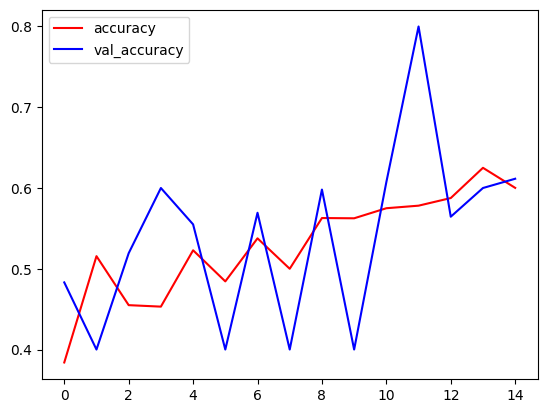

In [32]:
plt.plot(history.history['accuracy'],color='red',label='accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='val_accuracy')
plt.legend()
plt.show()

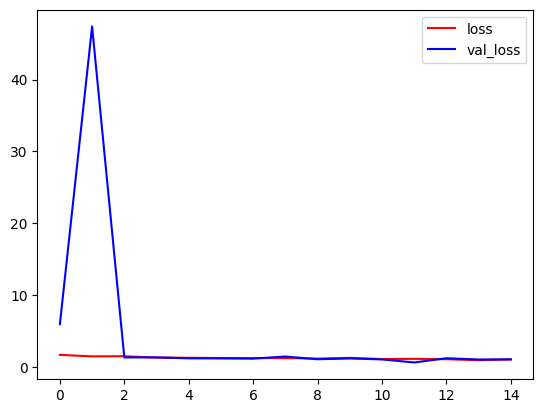

In [33]:
plt.plot(history.history['loss'],color='red',label='loss')
plt.plot(history.history['val_loss'],color='blue',label='val_loss')
plt.legend()
plt.show()

In [34]:
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)

print(f"Accuracy : {train_accu*100}")
print(f"Validation Accuracy : {test_accu*100}")

449/449 ━━━━━━━━━━━━━━━━━━━━ 351s 781ms/step - accuracy: 0.6039 - loss: 1.0594
113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.6065 - loss: 1.0579
Accuracy : 60.33996343612671
Validation Accuracy : 60.7690155506134


In [35]:
true_classes = test_generator.classes
true_classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [36]:
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
predicted_classes

  2/113 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step

W0000 00:00:1720887743.139995     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step


array([3, 6, 4, ..., 0, 0, 6])

In [37]:
class_labels = list(test_generator.class_indices.keys())
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [38]:
cm = confusion_matrix(true_classes, predicted_classes)
cm

array([[186,  18, 100, 250, 128, 161, 115],
       [ 23,   3,  15,  29,  10,  18,  13],
       [188,  37, 116, 239, 143, 197, 104],
       [336,  41, 197, 418, 241, 317, 224],
       [256,  43, 136, 273, 176, 203, 146],
       [209,  32, 136, 296, 209, 235, 130],
       [151,  24,  79, 224, 136, 132,  85]])

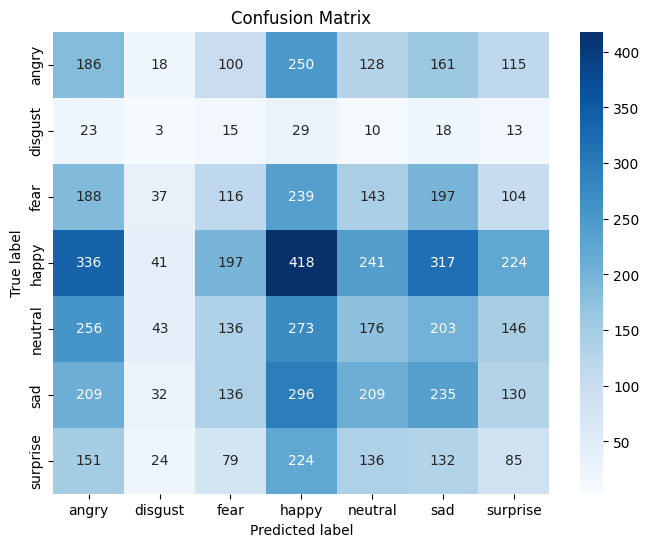

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.19      0.16       958
     disgust       0.02      0.03      0.02       111
        fear       0.15      0.11      0.13      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.17      0.14      0.15      1233
         sad       0.19      0.19      0.19      1247
    surprise       0.10      0.10      0.10       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



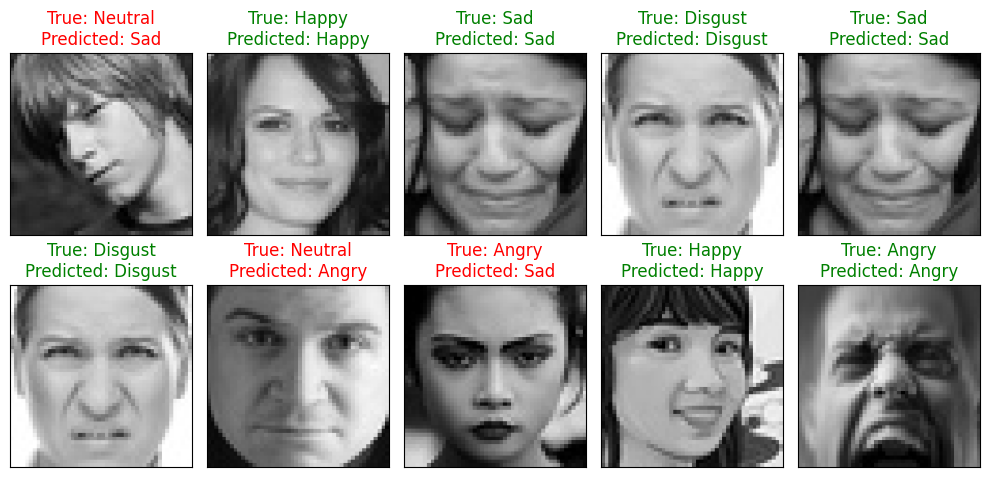

In [41]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [42]:
model.save_weights("/kaggle/working/Emotion_Detection/resnet50_transfer_learning/resnet50_model.weights.h5")

In [43]:
model.load_weights("/kaggle/working/Emotion_Detection/resnet50_transfer_learning/resnet50_model.weights.h5")

In [44]:
model_json = model.to_json()
with open("/kaggle/working/Emotion_Detection/resnet50_transfer_learning/resnet50_model.json", "w") as json_file:
    json_file.write(model_json)

In [45]:
json_file = open("/kaggle/working/Emotion_Detection/resnet50_transfer_learning/resnet50_model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/kaggle/working/Emotion_Detection/resnet50_transfer_learning/resnet50_model.weights.h5")

In [46]:
model.evaluate(test_generator)

  1/113 ━━━━━━━━━━━━━━━━━━━━ 9:02 5s/step - accuracy: 0.6406 - loss: 1.1733

W0000 00:00:1720887779.682253     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.6118 - loss: 1.0596


[1.0583704710006714, 0.607690155506134]